<a href="https://www.kaggle.com/code/ghazalehalizade/skin-cancer?scriptVersionId=247941133" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import needed modules

In [5]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

modules loaded


In [6]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.12.0


# **Data Preprocessing**

### **Read data and store it in dataframe**

**🧠 Goal:**
To convert the folder structure of images (e.g., train/benign/*.jpg, train/malignant/*.jpg) into a pandas DataFrame like this:

| filepaths                         | labels    |
| --------------------------------- | --------- |
| /kaggle/input/.../benign/1.jpg    | benign    |
| /kaggle/input/.../malignant/2.jpg | malignant |


In [7]:
train_data_dir = '/kaggle/input/skin-cancer-malignant-vs-benign/train'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [8]:
print(train_df.head())
print(train_df['labels'].value_counts())

                                           filepaths  labels
0  /kaggle/input/skin-cancer-malignant-vs-benign/...  benign
1  /kaggle/input/skin-cancer-malignant-vs-benign/...  benign
2  /kaggle/input/skin-cancer-malignant-vs-benign/...  benign
3  /kaggle/input/skin-cancer-malignant-vs-benign/...  benign
4  /kaggle/input/skin-cancer-malignant-vs-benign/...  benign
benign       1440
malignant    1197
Name: labels, dtype: int64


In [9]:
print(os.listdir('/kaggle/input/skin-cancer-malignant-vs-benign'))

['data', 'test', 'train']


In [10]:
# Generate data paths with labels
test_data_dir = '/kaggle/input/skin-cancer-malignant-vs-benign/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

### **Create image data generator**

In [11]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2637 validated image filenames belonging to 2 classes.
Found 660 validated image filenames belonging to 2 classes.


### **Show sample from train data**

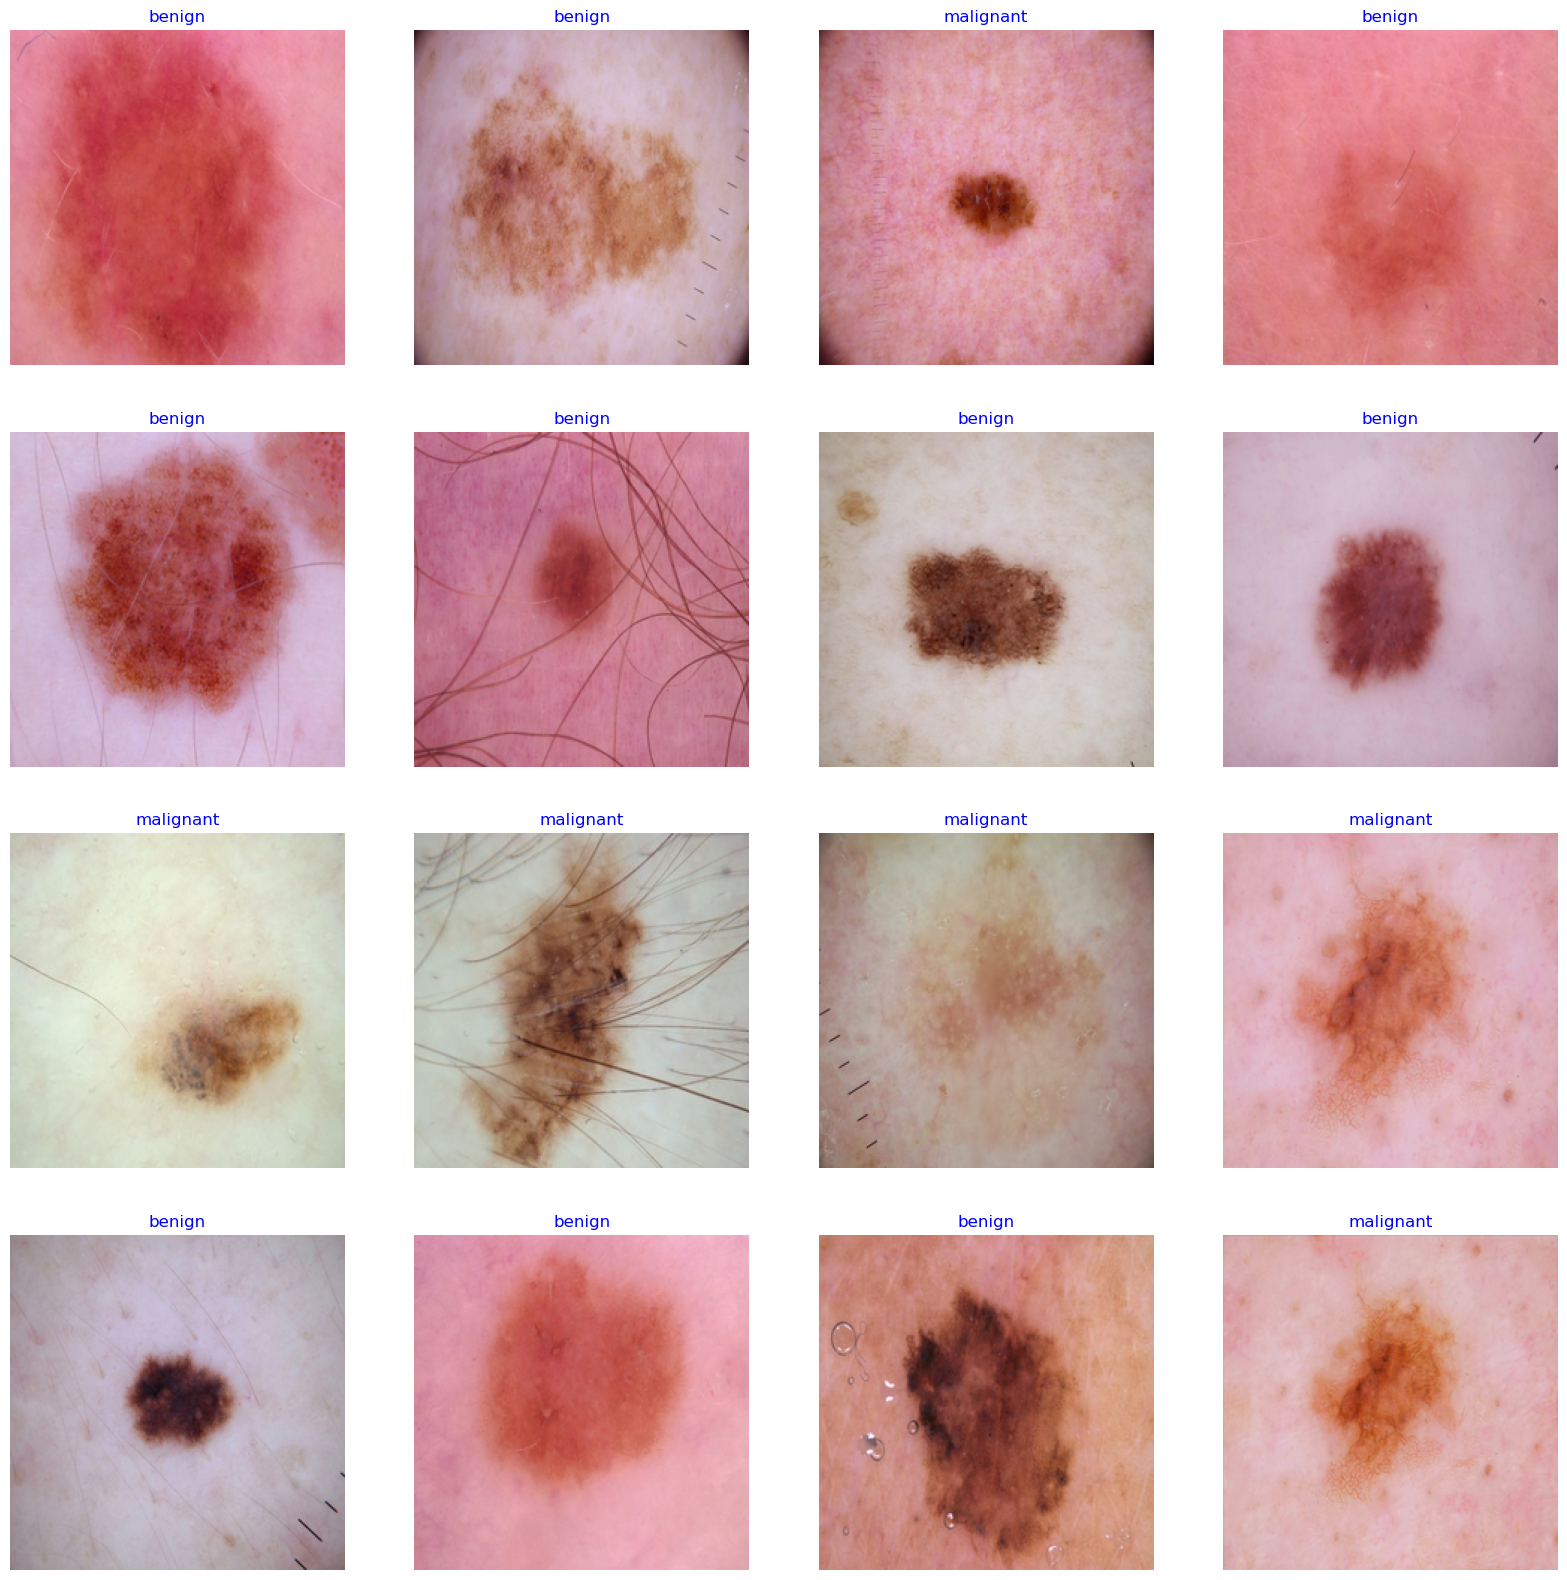

In [12]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# **Model Structure**

 **EfficientNetB0 model with training, validation, evaluation, and visualization**

#### **Generic Model Creation**

In [13]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, weights="imagenet", input_shape=img_shape, pooling='max'
)
base_model.trainable = False  # Freeze base model

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.02), activity_regularizer=regularizers.l1(0.01),
          bias_regularizer=regularizers.l1(0.01), activation='relu'),
    Dropout(rate=0.5, seed=123),
    Dense(class_count, activation='softmax')
])
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 4,383,141
Trainable params: 331,010
Non-tra

| Layer                 | Output Shape | Param #   | Purpose                |
| --------------------- | ------------ | --------- | ---------------------- |
| `efficientnetb0`      | (None, 1280) | 4,049,571 | Pretrained base        |
| `batch_normalization` | (None, 1280) | 5,120     | Normalize output       |
| `dense`               | (None, 256)  | 327,936   | First classifier layer |
| `dropout`             | (None, 256)  | 0         | Prevent overfitting    |
| `dense_1`             | (None, 2)    | 514       | Final softmax layer    |


#### **Train model**

In [14]:
epochs = 50   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/50


2025-06-29 06:56:05.517198: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


165/165 [==============================] - 32s 135ms/step - loss: 7.3987 - accuracy: 0.7812 - val_loss: 5.4694 - val_accuracy: 0.8030
Epoch 2/50
165/165 [==============================] - 8s 50ms/step - loss: 4.5119 - accuracy: 0.8252 - val_loss: 3.6998 - val_accuracy: 0.8288
Epoch 3/50
165/165 [==============================] - 8s 50ms/step - loss: 3.1430 - accuracy: 0.8415 - val_loss: 2.6499 - val_accuracy: 0.8424
Epoch 4/50
165/165 [==============================] - 8s 50ms/step - loss: 2.2778 - accuracy: 0.8601 - val_loss: 1.9867 - val_accuracy: 0.8379
Epoch 5/50
165/165 [==============================] - 8s 49ms/step - loss: 1.7240 - accuracy: 0.8661 - val_loss: 1.5411 - val_accuracy: 0.8515
Epoch 6/50
165/165 [==============================] - 8s 51ms/step - loss: 1.3480 - accuracy: 0.8756 - val_loss: 1.2517 - val_accuracy: 0.8530
Epoch 7/50
165/165 [==============================] - 8s 49ms/step - loss: 1.0923 - accuracy: 0.8836 - val_loss: 1.0424 - val_accuracy: 0.8455
Epoch 8/

#### **Display model performance**

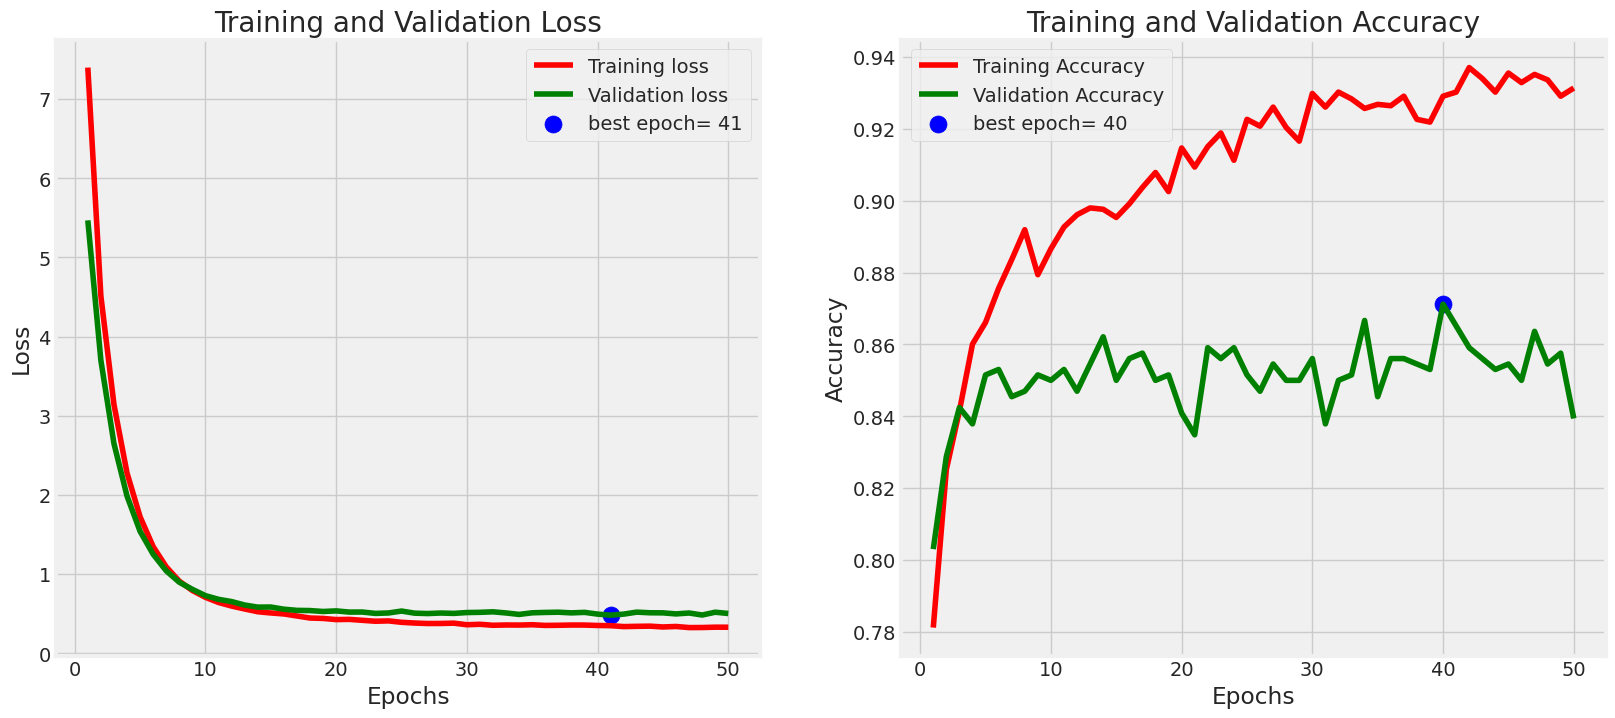

In [15]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluate model**

In [16]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

10/10 [==============================] - 1s 46ms/step - loss: 0.5063 - accuracy: 0.8750
Train Loss:  0.24785569310188293
Train Accuracy:  1.0
--------------------
Test Loss:  0.5062653422355652
Test Accuracy:  0.875


# **Get Predictions**

In [17]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

#### **Confusion Matrics and Classification Report**

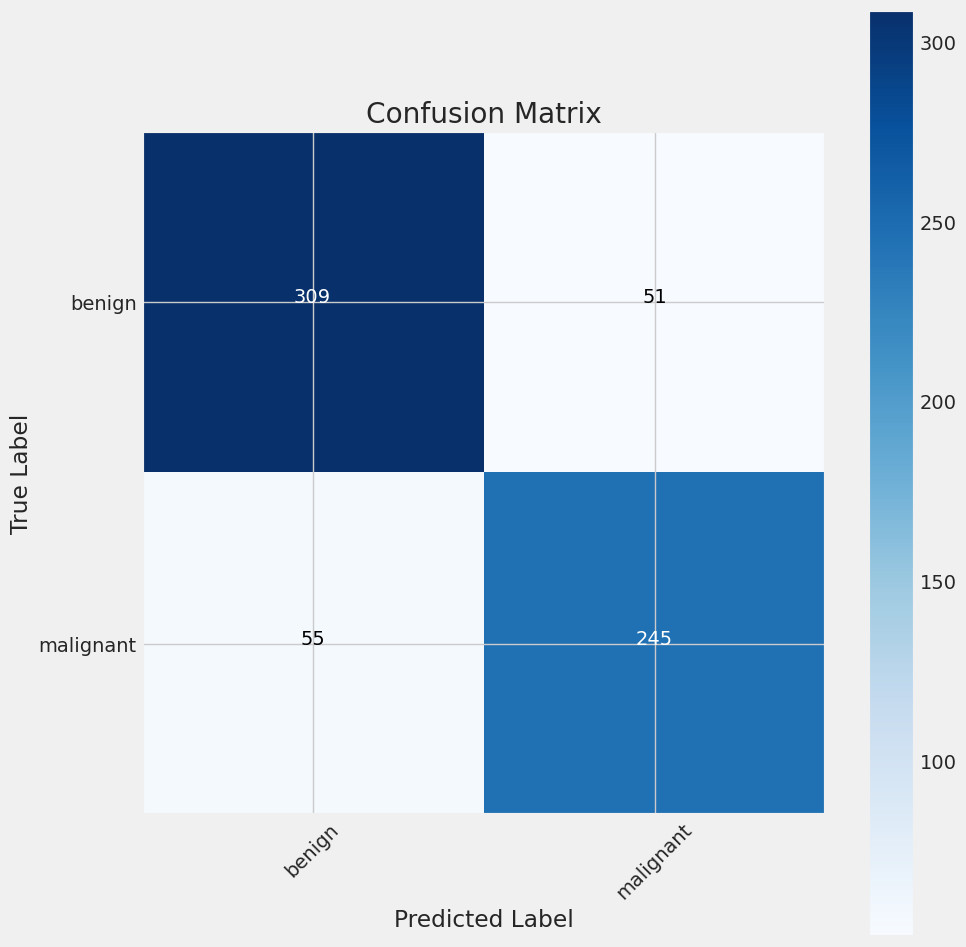

In [18]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [19]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      benign       0.85      0.86      0.85       360
   malignant       0.83      0.82      0.82       300

    accuracy                           0.84       660
   macro avg       0.84      0.84      0.84       660
weighted avg       0.84      0.84      0.84       660



**ResNet50**

Import Modules 

In [20]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [30]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # to define number of classes in dense layer

# create pre-trained model (ResNet50 from ResNet family)
base_model = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=img_shape, pooling='max'
)
base_model.trainable = False  # Freeze base model

model_resnet = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.02), activity_regularizer=regularizers.l1(0.01),
          bias_regularizer=regularizers.l1(0.01), activation='relu'),
    Dropout(rate=0.5, seed=123),
    Dense(class_count, activation='softmax')
])
model_resnet.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_resnet.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 24,120,962
Trainable params: 529,154
Non-trainable params: 23,591,808
____________________________________

In [32]:
from sklearn.model_selection import train_test_split

# Split train_df into training and validation sets
train_df_, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'], random_state=42)


In [33]:
# Data augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# No augmentation for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df_,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

# Validation generator
val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2109 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.


In [34]:
# Set number of epochs
epochs = 50

# Train the model
history_resnet = model_resnet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    shuffle=True
)


Epoch 1/50
66/66 [==============================] - 31s 415ms/step - loss: 4.6921 - accuracy: 0.7710 - val_loss: 3.9305 - val_accuracy: 0.4545
Epoch 2/50
66/66 [==============================] - 26s 392ms/step - loss: 2.2836 - accuracy: 0.7748 - val_loss: 2.7120 - val_accuracy: 0.4545
Epoch 3/50
66/66 [==============================] - 26s 392ms/step - loss: 1.8137 - accuracy: 0.7852 - val_loss: 1.9932 - val_accuracy: 0.4564
Epoch 4/50
66/66 [==============================] - 26s 399ms/step - loss: 1.5023 - accuracy: 0.8028 - val_loss: 1.6411 - val_accuracy: 0.4773
Epoch 5/50
66/66 [==============================] - 26s 389ms/step - loss: 1.2950 - accuracy: 0.8037 - val_loss: 1.3145 - val_accuracy: 0.7841
Epoch 6/50
66/66 [==============================] - 26s 393ms/step - loss: 1.1527 - accuracy: 0.7956 - val_loss: 1.1268 - val_accuracy: 0.8144
Epoch 7/50
66/66 [==============================] - 26s 397ms/step - loss: 1.0320 - accuracy: 0.7914 - val_loss: 0.9898 - val_accuracy: 0.8258

In [38]:
print(history_resnet.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [39]:
def plot_training_history(history, model_name="Model"):
    acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history['loss']
    val_loss = history.history.get('val_loss', [])

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='green')
    if val_acc:
        plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='red')
    if val_loss:
        plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
    plt.title(f'{model_name} - Loss')
    plt.legend()

    plt.show()


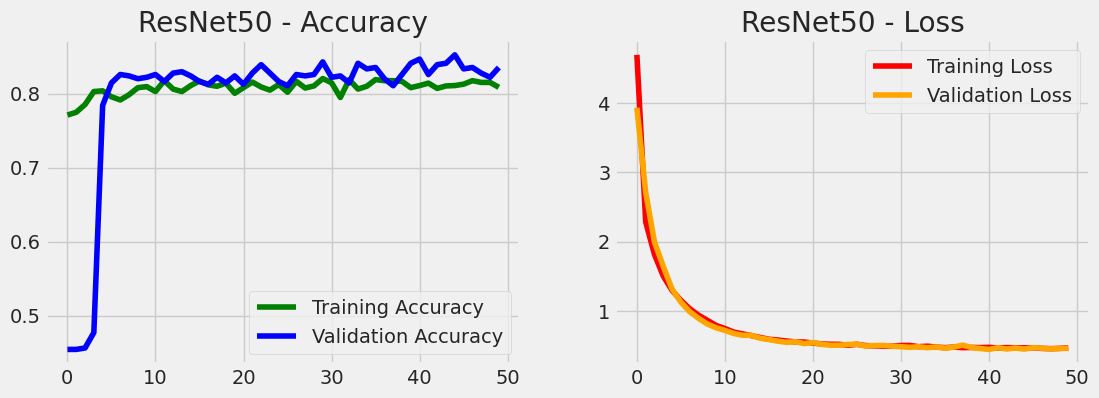

In [40]:
plot_training_history(history_resnet, "ResNet50")

In [41]:
# Predict class probabilities
y_pred_probs = model_resnet.predict(test_gen, verbose=1)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_gen.classes

# Class labels
class_labels = list(test_gen.class_indices.keys())

42/42 [==============================] - 3s 60ms/step


Classification Report:
              precision    recall  f1-score   support

      benign       0.62      0.98      0.76       360
   malignant       0.91      0.27      0.42       300

    accuracy                           0.66       660
   macro avg       0.76      0.62      0.59       660
weighted avg       0.75      0.66      0.60       660



<Figure size 600x600 with 0 Axes>

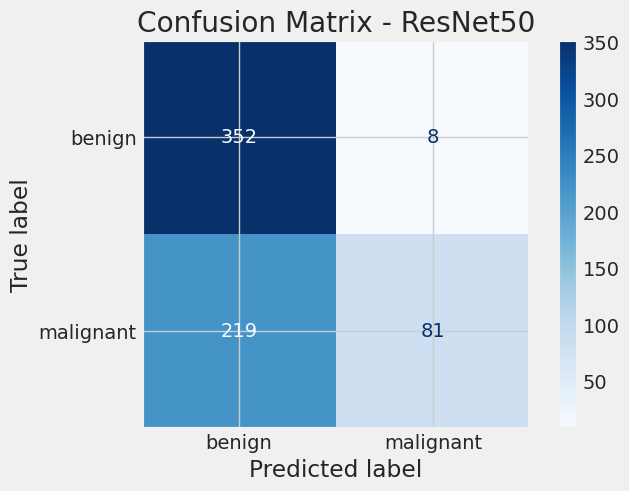

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - ResNet50")
plt.show()


In [ ]:
# Save training history
import pickle
with open("resnet50_history.pkl", "wb") as f:
    pickle.dump(history_resnet.history, f)

# Save final model
resnet_model.save("resnet50_model.keras")

EfficientNetB3 

In [ ]:
# Create Model Structure for EfficientNetB3
img_size = (300, 300)  # B3 recommends 300x300 input
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # number of classes

# Load the EfficientNetB3 base model
base_model_b3 = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='max'
)
base_model_b3.trainable = False  # Freeze base model

# Define the model
model_b3 = tf.keras.Sequential([
    base_model_b3,
    tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.02),
                          activity_regularizer=tf.keras.regularizers.l1(0.01),
                          bias_regularizer=tf.keras.regularizers.l1(0.01),
                          activation='relu'),
    tf.keras.layers.Dropout(rate=0.5, seed=123),
    tf.keras.layers.Dense(class_count, activation='softmax')
])

# Compile the model
model_b3.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
model_b3.summary()


#### **Save model**

In [ ]:
import os
os.listdir()

In [ ]:
model.save("skincancer.h5")

In [ ]:
loaded_model = tf.keras.models.load_model('/kaggle/working/skincancer.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])


## **Prediction using loaded_model**

In [ ]:
loaded_model = tf.keras.models.load_model('/kaggle/working/skincancer.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = '/kaggle/input/skin-cancer-malignant-vs-benign/test/benign/1023.jpg'
image = Image.open(image_path)
# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Benign', 'Malignant']
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

## Convert to tflite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) 
tflite_model = converter.convert() 

print("model converted")

# Save the model. 
with open('Brain.tflite', 'wb') as f:
    f.write(tflite_model)